# Exploration of alternatives to initial evaluation scores

As the initial union-version of precision and recall were insufficient to evaluate and compare HyAsP, we explored several other options, including the best-version of precision and recall (initially called max-precision / max-recall, which still can be found in some tables and plots).
We also looked at the distributions of the scores, the relation between score and plasmid length and the number of high-quality pairs of predicted and reference plasmids.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from Bio import SeqIO

pd.options.display.max_rows = None

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}, data_types = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h, dtype = data_types)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df       

def analyse(run, samples, hq_threshold):
    df_references = []
    df_predictions = []
    df_pairs = []

    for sample_id in samples:
        # evaluation files
        files = dict()
        files['HyAsP'] = '%s/sample_%i/eval/greedy/greedy_eval.csv' % (run, sample_id)
        files['MOB-recon'] = '%s/sample_%i/eval/mob_recon/mob_recon_eval.csv' % (run, sample_id)
        files['plasmidSPAdes'] = '%s/sample_%i/eval/plasmidspades/plasmidspades_eval.csv' % (run, sample_id)
        files['Recycler'] = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/eval/%i_recycler_eval.csv' % sample_id

        # reference information
        _, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(files['HyAsP'])
        num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

        ref_plasmids = list_plasmids(files['HyAsP'], skip_ref_plasmids, num_ref_plasmids)
        ref_plasmids.set_index('plasmid', inplace = True)

        for tool in files:
            if os.path.isfile(files[tool]): 
                _, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores = parse_structure(files[tool])
                num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2

                max_recall = read_table(files[tool], skip_ref_by_pred, num_pred_plasmids, data_types = {'Unnamed: 0': str})
                max_recall = max_recall.loc[:, max_recall.columns != 'Unnamed: 0'].max().to_frame()
                max_recall.columns = ['proportion']

                union_recall = read_table(files[tool], skip_ref_by_all, num_ref_plasmids, data_types = {'plasmid': str, 'proportion': float})
                union_recall.set_index('plasmid', inplace = True)

                for pla, row in ref_plasmids.iterrows():
                    if num_pred_plasmids > 0:
                        df_references.append([tool, sample_id, pla, row['length (nt)'], max_recall.at[pla, 'proportion'], union_recall.at[pla, 'proportion']])
                    else:
                        df_references.append([tool, sample_id, pla, row['length (nt)'], 0, 0])


                if num_pred_plasmids > 0:
                    pred_plasmids = list_plasmids(files[tool], skip_pred_plasmids, num_pred_plasmids)
                    pred_plasmids.set_index('plasmid', inplace = True)

                    max_precision = read_table(files[tool], skip_pred_by_ref, num_ref_plasmids, data_types = {'Unnamed: 0': str})
                    max_precision = max_precision.loc[:, max_precision.columns != 'Unnamed: 0'].max().to_frame()
                    max_precision.columns = ['proportion']

                    union_precision = read_table(files[tool], skip_pred_by_all, num_pred_plasmids, data_types = {'plasmid': str, 'proportion': float})
                    union_precision['plasmid'] = union_precision['plasmid'].astype(str)
                    union_precision.set_index('plasmid', inplace = True)

                    for pla, row in pred_plasmids.iterrows():
                        df_predictions.append([tool, sample_id, pla, row['length (nt)'], max_precision.at[pla, 'proportion'], union_precision.at[pla, 'proportion']])
                        
                    
                num_pairs = skip_summary_scores - skip_mutual - 2
                pairs = read_table(files[tool], skip_mutual, num_pairs, s = ' ', h = None).astype(str)
                if len(pairs.columns) > 1:
                    pairs.drop(columns = [1, 4], inplace = True)
                    pairs.columns = ['reference', 'prediction', 'recall', 'precision']
                    pairs['recall'] = [float(val[1:]) for val in pairs['recall']]
                    pairs['precision'] = [float(val[:-1]) for val in pairs['precision']]

                    for i, row in pairs.iterrows():
                        if row['recall'] >= hq_threshold and row['precision'] >= hq_threshold:
                            df_pairs.append([tool, sample_id, row['reference'], row['prediction'], row['recall'], row['precision']])

            else:
                for pla, row in ref_plasmids.iterrows():
                    df_references.append([tool, sample_id, pla, row['length (nt)'], 0, 0])
                    
    df_references = pd.DataFrame(df_references, columns = ['tool', 'sample_id', 'plasmid_id', 'length', 'max_recall', 'union_recall'])
    df_predictions = pd.DataFrame(df_predictions, columns = ['tool', 'sample_id', 'plasmid_id', 'length', 'max_precision', 'union_precision'])
    df_pairs = pd.DataFrame(df_pairs, columns = ['tool', 'sample_id', 'reference', 'prediction', 'recall', 'precision'])

    return df_references, df_predictions, df_pairs

def aggregate(df_references, df_predictions):
    contents = []

    for m in ['HyAsP', 'MOB-recon', 'plasmidSPAdes', 'Recycler']:
        t = df_references.loc[df_references['tool'] == m]
        agg_recall_union = 0
        agg_recall_max = 0
        len_sum_refs = 0
        for i, row in t.iterrows():
            agg_recall_union += row['length'] * row['union_recall']
            agg_recall_max += row['length'] * row['max_recall']
            len_sum_refs += row['length']

        t = df_predictions.loc[df_predictions['tool'] == m]
        agg_precision_union = 0
        agg_precision_max = 0
        len_sum_preds = 0
        for i, row in t.iterrows():
            agg_precision_union += row['length'] * row['union_precision']
            agg_precision_max += row['length'] * row['max_precision']
            len_sum_preds += row['length']

        recall_union = agg_recall_union / len_sum_refs
        recall_max = agg_recall_max / len_sum_refs

        precision_union = agg_precision_union / len_sum_preds
        precision_max = agg_precision_max / len_sum_preds

        f1_union = 2 * precision_union * recall_union / (precision_union + recall_union)
        f1_max = 2 * precision_max * recall_max / (precision_max + recall_max)

        contents.append([m, 'union', precision_union, recall_union, f1_union])
        contents.append([m, 'max', precision_max, recall_max, f1_max])

    return pd.DataFrame(contents, columns = ['tool', 'evaluation', 'precision', 'recall', 'f1'])

def hist_plots(df_references, df_predictions):
    recall_rows = ['max_recall', 'union_recall']
    precision_rows = ['max_precision', 'union_precision']
    columns = ['MOB-recon', 'HyAsP', 'plasmidSPAdes', 'Recycler']
    colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e']
    
    fig, axes = plt.subplots(nrows = len(recall_rows) + len(precision_rows), ncols = len(columns), figsize = (20, 15), sharey = 'row')

    for i in range(0, len(recall_rows)):
        for j in range(0, len(columns)):
            axes[i][j].hist(df_references.loc[df_references['tool'] == columns[j]][recall_rows[i]], color = colours[j])
            axes[i][j].set_xlabel('%s' % recall_rows[i])
            axes[i][j].set_ylabel('count')

    for i in range(0, len(precision_rows)):
        for j in range(0, len(columns)):
            axes[i + len(recall_rows)][j].hist(df_predictions.loc[df_predictions['tool'] == columns[j]][precision_rows[i]], color = colours[j])
            axes[i + len(recall_rows)][j].set_xlabel('%s' % precision_rows[i])
            axes[i + len(recall_rows)][j].set_ylabel('count')

    for j in range(0, len(columns)):
        axes[0][j].set_title(columns[j], fontsize = 20)

    plt.tight_layout()
    
def scatter_plots(df_references, df_predictions):
    recall_rows = ['max_recall', 'union_recall']
    precision_rows = ['max_precision', 'union_precision']
    columns = ['MOB-recon', 'HyAsP', 'plasmidSPAdes', 'Recycler']
    colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e']
    
    fig, axes = plt.subplots(nrows = len(recall_rows) + len(precision_rows), ncols = len(columns), figsize = (20, 15), sharey = 'row')

    for i in range(0, len(recall_rows)):
        for j in range(0, len(columns)):
            df = df_references.loc[df_references['tool'] == columns[j]]
            axes[i][j].scatter(df['length'], df[recall_rows[i]], s = 10, color = colours[j])
            axes[i][j].set_xlabel('reference length')
            axes[i][j].set_ylabel('%s' % recall_rows[i])

    for i in range(0, len(precision_rows)):
        for j in range(0, len(columns)):
            df = df_predictions.loc[df_predictions['tool'] == columns[j]]
            axes[i + len(recall_rows)][j].scatter(df['length'], df[precision_rows[i]], s = 10, color = colours[j])
            axes[i + len(recall_rows)][j].set_xlabel('prediction length')
            axes[i + len(recall_rows)][j].set_ylabel('%s' % precision_rows[i])

    for j in range(0, len(columns)):
        axes[0][j].set_title(columns[j], fontsize = 20)

    plt.tight_layout()
    
def pretty_plots(full_df, cols, col_titles, xlabel, name):
    rows = ['MOB-recon', 'HyAsP', 'plasmidSPAdes', 'Recycler']
    colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e']
    
    fig, axes = plt.subplots(nrows = len(rows), ncols = len(cols), figsize = (20, 20), sharey = 'row', sharex = 'col')

    for i in range(0, len(rows)):
        for j in range(0, len(cols)):
            df = full_df.loc[full_df['tool'] == rows[i]]
            axes[i][j].scatter(df['length'], df[cols[j]], s = 10, color = colours[i])
            axes[i][j].tick_params(labelsize = 15)
        axes[i][0].set_ylabel('%s' % rows[i], fontsize = 25)

    for j in range(0, len(cols)):
        axes[0][j].set_title(col_titles[j], fontsize = 30)
        axes[-1][j].set_xlabel(xlabel, fontsize = 25)

    plt.tight_layout()
    
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches = 'tight')

    
def hq_one_way(df_references, df_predictions, hq_threshold):
    contents = []
    
    for t in ['HyAsP', 'MOB-recon', 'plasmidSPAdes', 'Recycler']:
        df = df_references.loc[df_references['tool'] == t]
        num_references = len(df)
        num_ref_hq_union = len(df.loc[df_references['union_recall'] >= 0.9])
        num_ref_hq_max = len(df.loc[df_references['max_recall'] >= 0.9])

        df = df_predictions.loc[df_predictions['tool'] == t]
        num_predictions = len(df)
        num_pred_hq_union = len(df.loc[df_predictions['union_precision'] >= 0.9])
        num_pred_hq_max = len(df.loc[df_predictions['max_precision'] >= 0.9])
        
        contents.append([t, num_references, num_ref_hq_union, num_ref_hq_max, num_predictions, num_pred_hq_union, num_pred_hq_max])
        
    return pd.DataFrame(contents, columns = ['tool', 'num_references', 'num_ref_hq_union', 'num_ref_hq_max', 'num_predictions', 'num_pred_hq_union', 'num_pred_hq_max'])


## MOB-database

In [4]:
run = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_mob_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]
threshold = 0.9

mob_references, mob_predictions, mob_pairs = analyse(run, samples, threshold)

**Aggregated scores over all test samples**

In [5]:
aggregate(mob_references, mob_predictions)

,tool,evaluation,precision,recall,f1
0,HyAsP,union,0.934516,0.775171,0.847418
1,HyAsP,max,0.887890,0.556486,0.684168
2,MOB-recon,union,0.760242,0.583911,0.660511
3,MOB-recon,max,0.756172,0.474530,0.583125
4,plasmidSPAdes,union,0.659212,0.741985,0.698154
5,plasmidSPAdes,max,0.560784,0.736594,0.636777
6,Recycler,union,0.349300,0.103779,0.160017
7,Recycler,max,0.349300,0.103061,0.159162


**Precision**: almost no difference for MOB-recon; HyAsP still highest   
**Recall**: almost no difference for plasmidSPAdes; HyAsP still better than MOB-recon but worse than plasmidSPAdes   
**F1 score**: max notably lower for all tools; largest difference for HyAsP but still highest

**Distributions of scores over plasmids from all test samples**

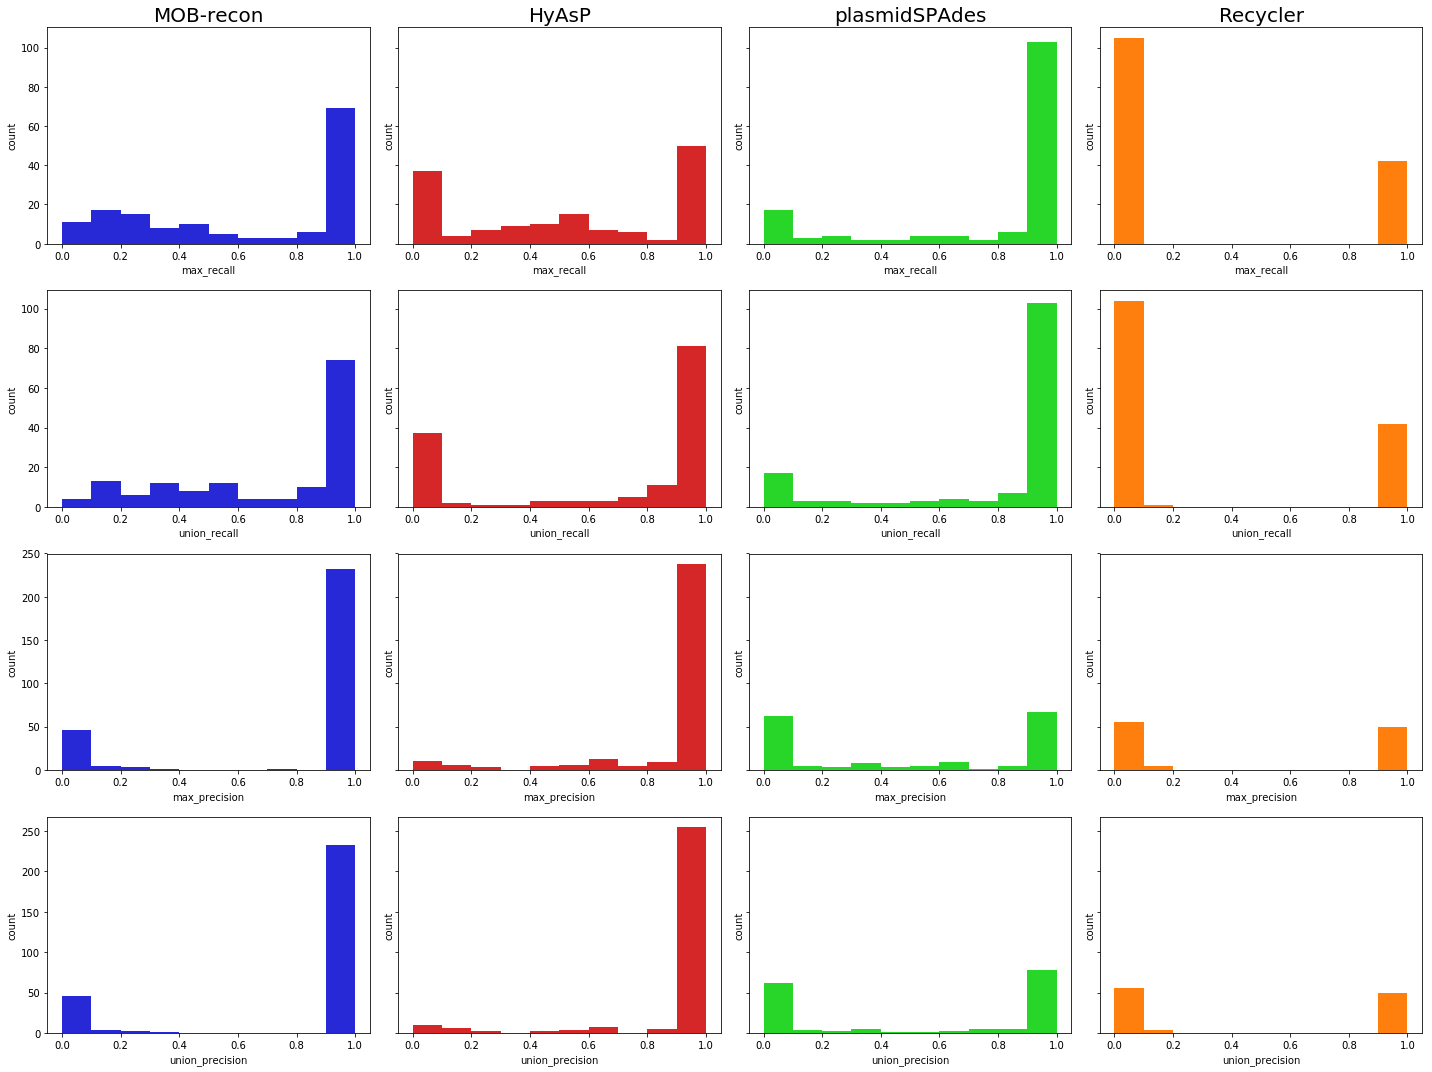

In [6]:
hist_plots(mob_references, mob_predictions)

**Length of reference (predicted) plasmid vs recall (precision) over plasmids from all test samples**

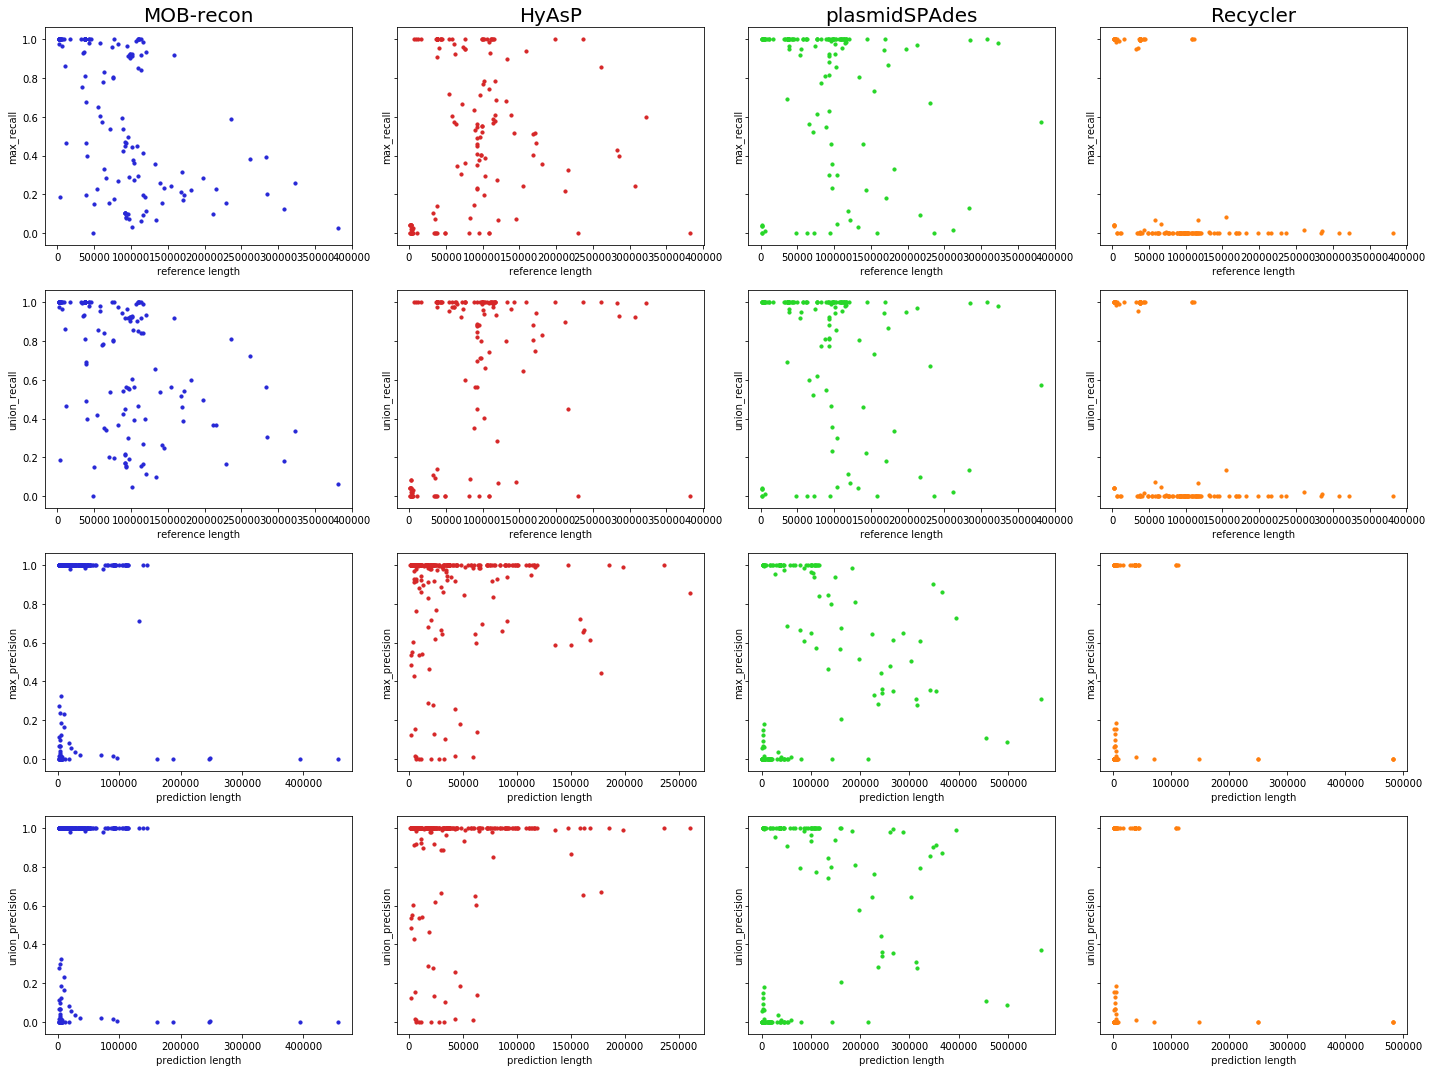

In [7]:
scatter_plots(mob_references, mob_predictions)

*Prettier plots for use in the supplement*

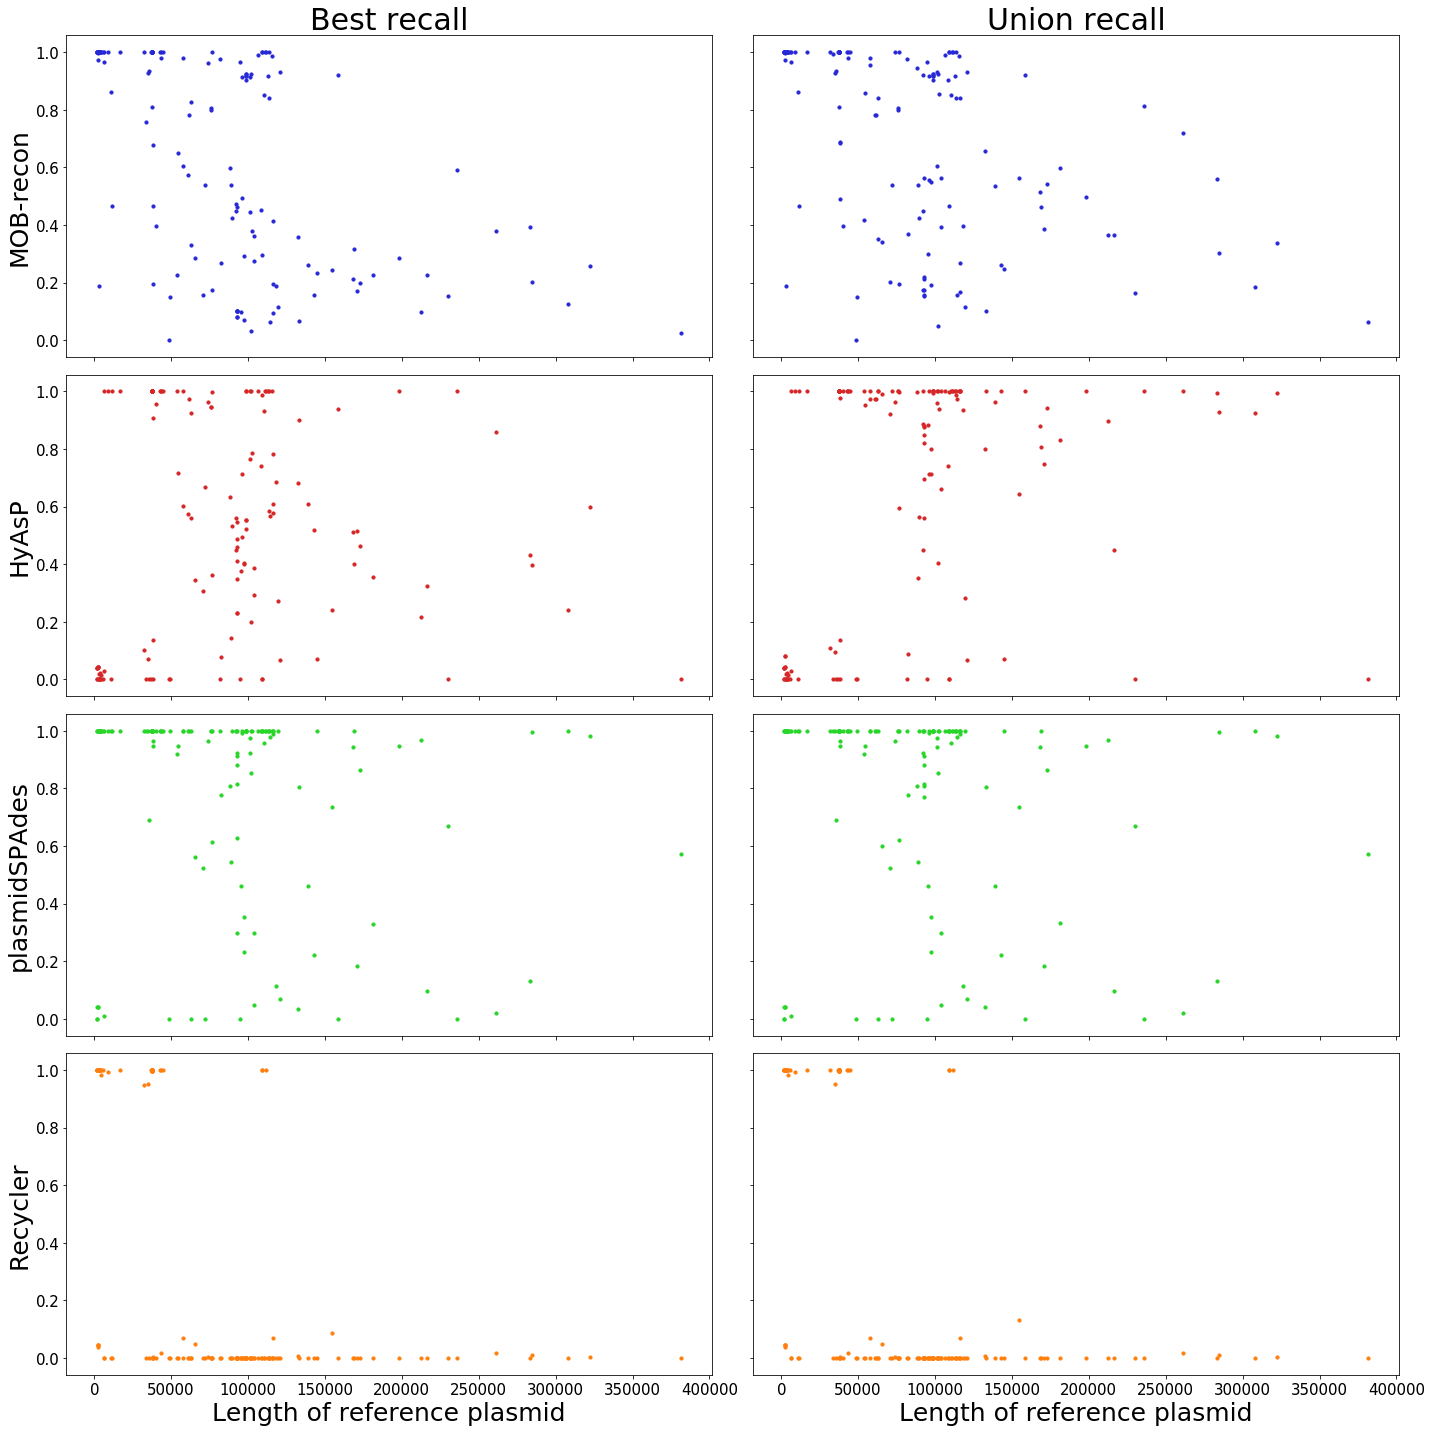

In [9]:
cols = ['max_recall', 'union_recall']
col_titles = ['Best recall', 'Union recall']
xlabel = 'Length of reference plasmid'

pretty_plots(mob_references, cols, col_titles, xlabel, 'length_vs_recall_mob')

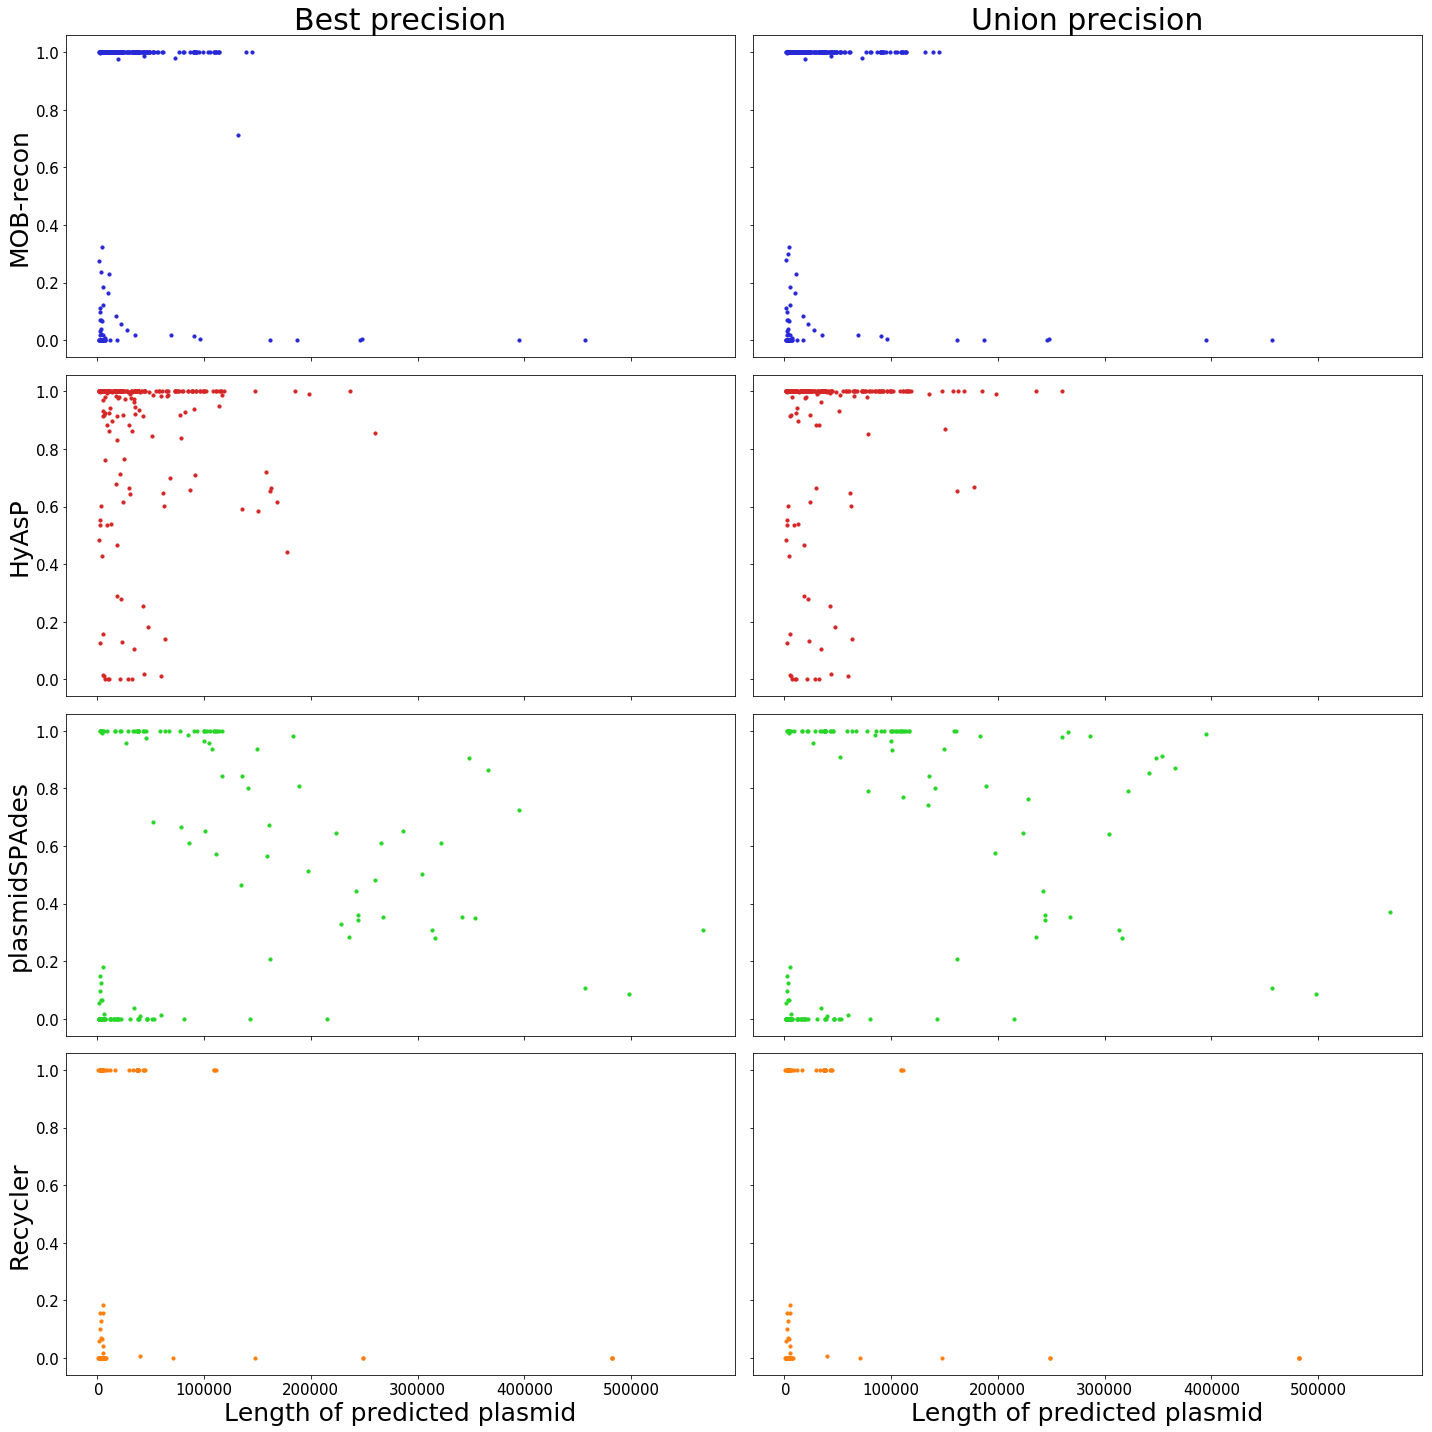

In [10]:
cols = ['max_precision', 'union_precision']
col_titles = ['Best precision', 'Union precision']
xlabel = 'Length of predicted plasmid'

pretty_plots(mob_predictions, cols, col_titles, xlabel, 'length_vs_precision_mob')

*Threshold on precision / recall for high quality*

In [8]:
threshold

0.9

**Number of high-quality pairs between references and predictions (high recall and precision)**

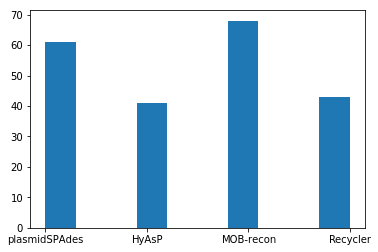

In [9]:
plt.hist(list(mob_pairs['tool']));

*Proportion of references (in number of references) matched with high precision and recall*

In [10]:
mob_pairs['tool'].value_counts() / mob_references['tool'].value_counts()

HyAsP            0.278912
MOB-recon        0.462585
Recycler         0.292517
plasmidSPAdes    0.414966
Name: tool, dtype: float64

*Proportion of references (in number of nucleotides) matched with high precision and recall*

In [11]:
ref_lengths = dict()
for i, row in mob_references.iterrows():
    ref_lengths[row['plasmid_id']] = row['length']
total_ref_len = sum([ref_lengths[i] for i in ref_lengths])
len_per_pool = [(sum([ref_lengths[i] for i in mob_pairs[mob_pairs['tool'] == t]['reference'].unique()])) / total_ref_len for t in mob_references['tool'].unique()]

pd.Series(data = len_per_pool, index = mob_references['tool'].unique())

Recycler         0.100085
plasmidSPAdes    0.291144
MOB-recon        0.266965
HyAsP            0.221424
dtype: float64

**Number of references (predictions) with high recall (precision)**

*Towards recall*: Over all samples, `num_references` plasmids were expected, of which `num_ref_hq_union` resp. `num_ref_hq_max` were sufficiently covered by the predicted plasmids, using (per sample) all predictions resp. only the most-fitting one.

*Towards precision*: Similarly, `num_predictions` plasmids were predicted, of which `num_pred_hq_union` resp. `num_pred_hq_max` were sufficiently covered by the expected reference plasmids, using (per sample) all references resp. only the most-fitting one.

In [12]:
hq_one_way(mob_references, mob_predictions, threshold)

,tool,num_references,num_ref_hq_union,num_ref_hq_max,num_predictions,num_pred_hq_union,num_pred_hq_max
0,HyAsP,147,81,50,293,255,238
1,MOB-recon,147,74,69,287,233,232
2,plasmidSPAdes,147,103,103,166,78,67
3,Recycler,147,42,42,108,49,49


## NCBI-database

In [11]:
run = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_ncbi_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]

ncbi_references, ncbi_predictions, ncbi_pairs = analyse(run, samples, 0.9)

**Aggregated scores over all test samples**

In [12]:
aggregate(ncbi_references, ncbi_predictions)

,tool,evaluation,precision,recall,f1
0,HyAsP,union,0.871447,0.898824,0.884924
1,HyAsP,max,0.825117,0.621696,0.709106
2,MOB-recon,union,0.760242,0.583911,0.660511
3,MOB-recon,max,0.756172,0.476373,0.584514
4,plasmidSPAdes,union,0.659212,0.741985,0.698154
5,plasmidSPAdes,max,0.560784,0.736594,0.636777
6,Recycler,union,0.349300,0.103779,0.160017
7,Recycler,max,0.349300,0.103061,0.159162


**Precision**: almost no difference for MOB-recon; HyAsP still highest   
**Recall**: almost no difference for plasmidSPAdes; HyAsP still better than MOB-recon but worse than plasmidSPAdes   
**F1 score**: max notably lower for all tools; largest difference for HyAsP but still highest

**Distributions of scores over plasmids from all test samples**

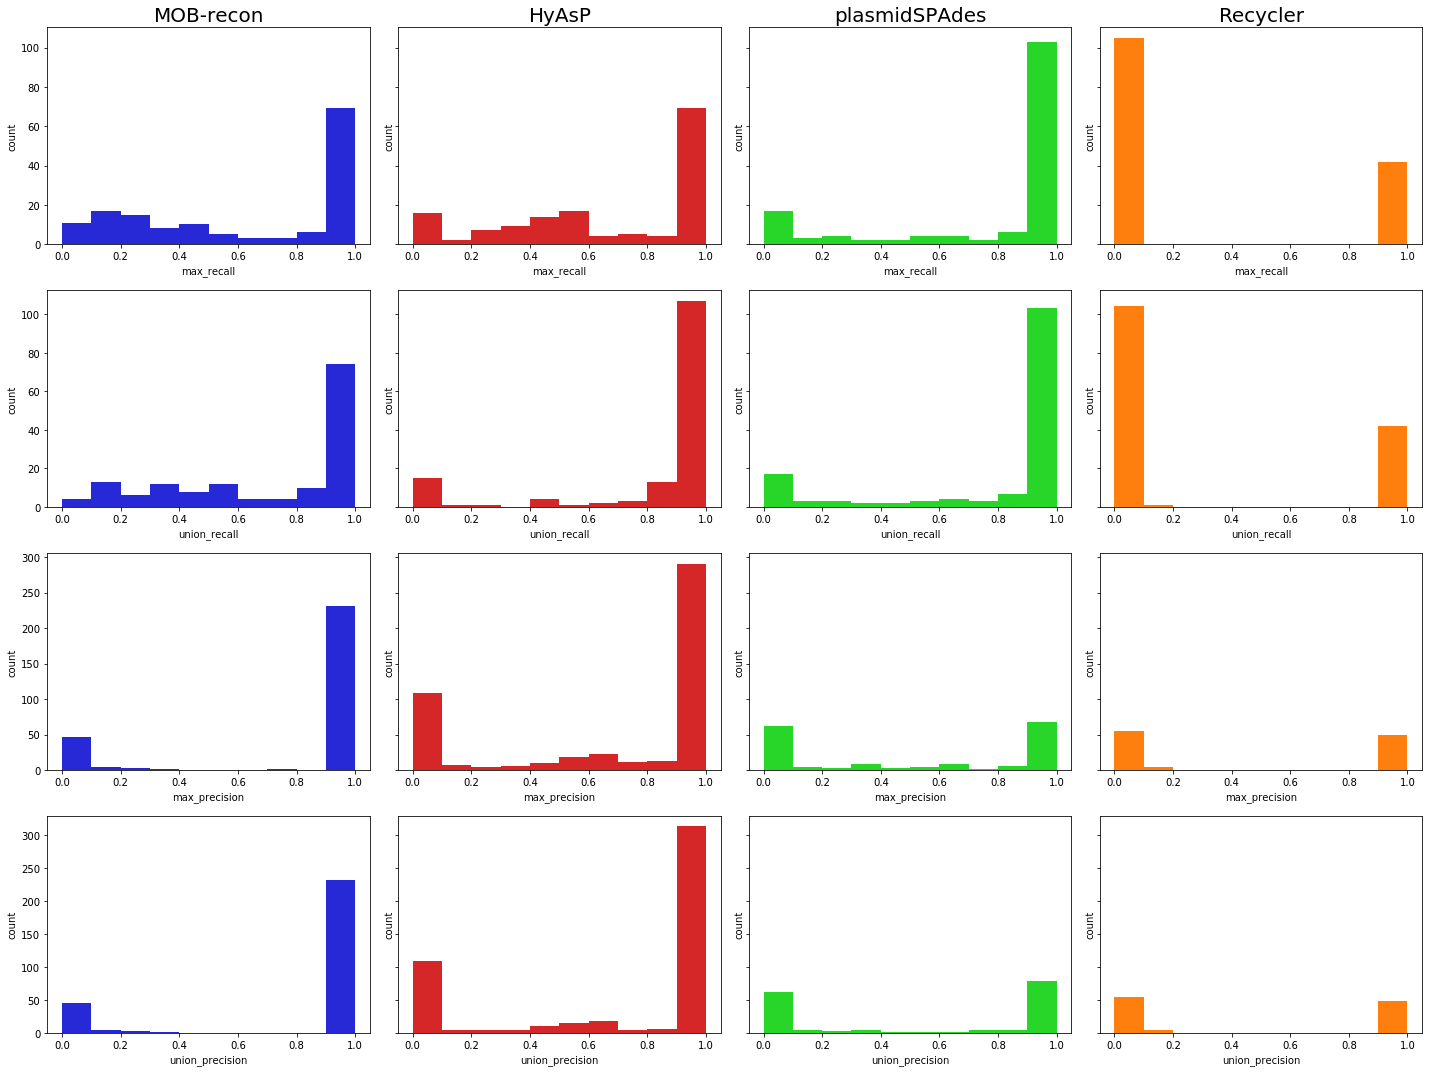

In [13]:
hist_plots(ncbi_references, ncbi_predictions)

**Length of reference (predicted) plasmid vs recall (precision) over plasmids from all test samples**

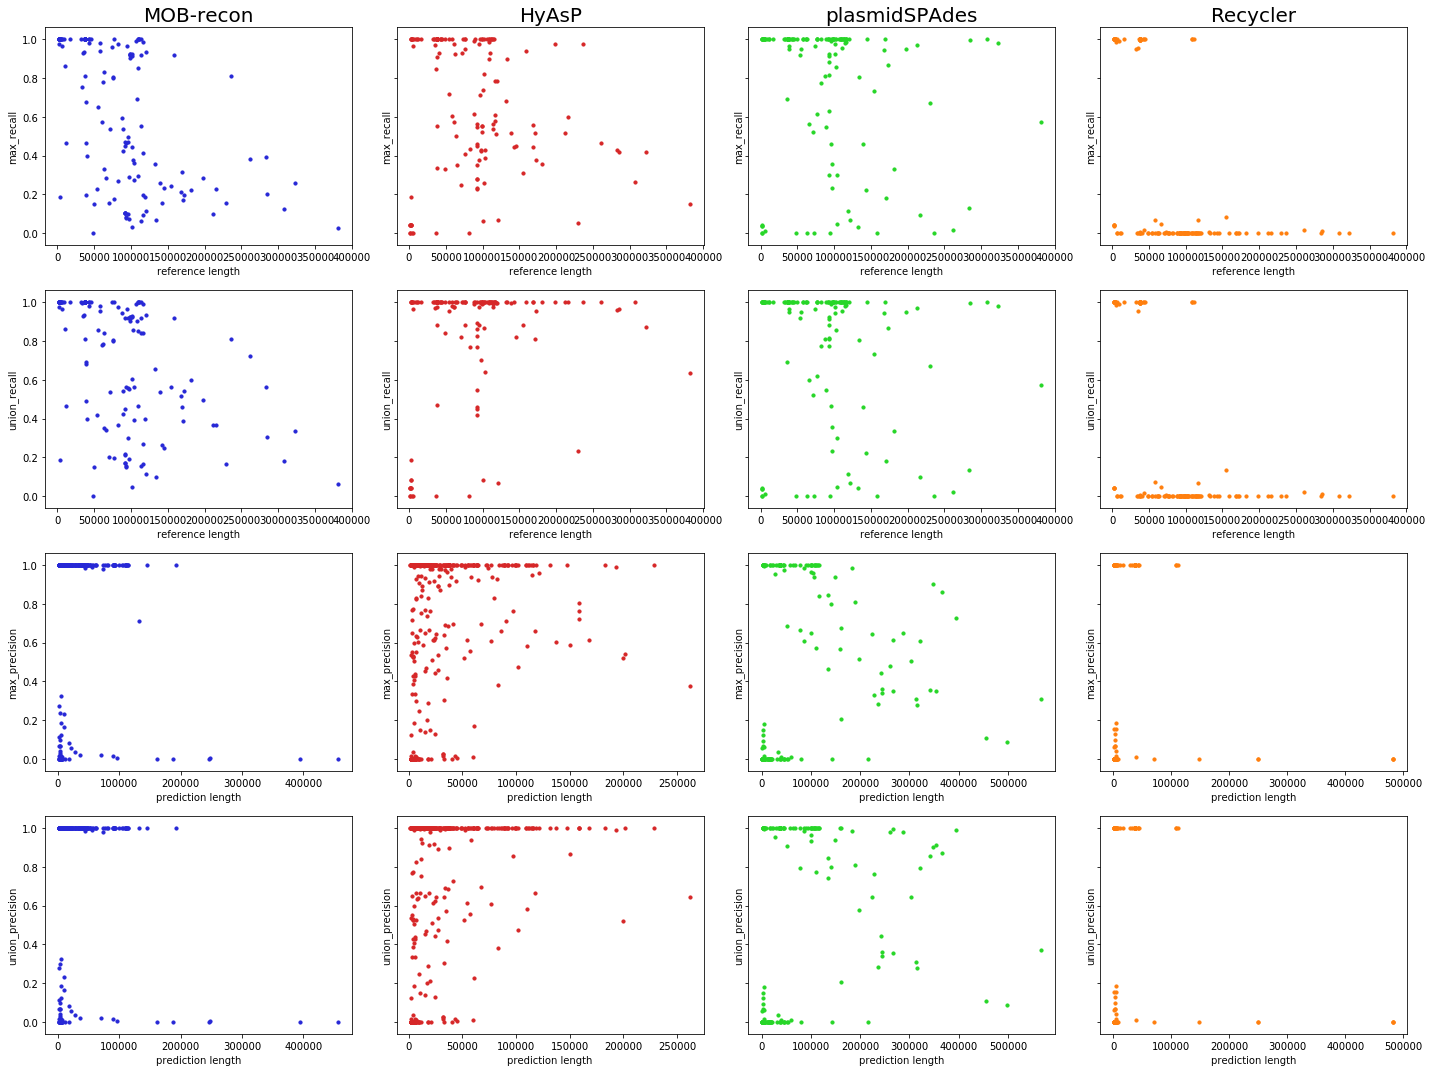

In [14]:
scatter_plots(ncbi_references, ncbi_predictions)

*Prettier plots for use in the supplement*

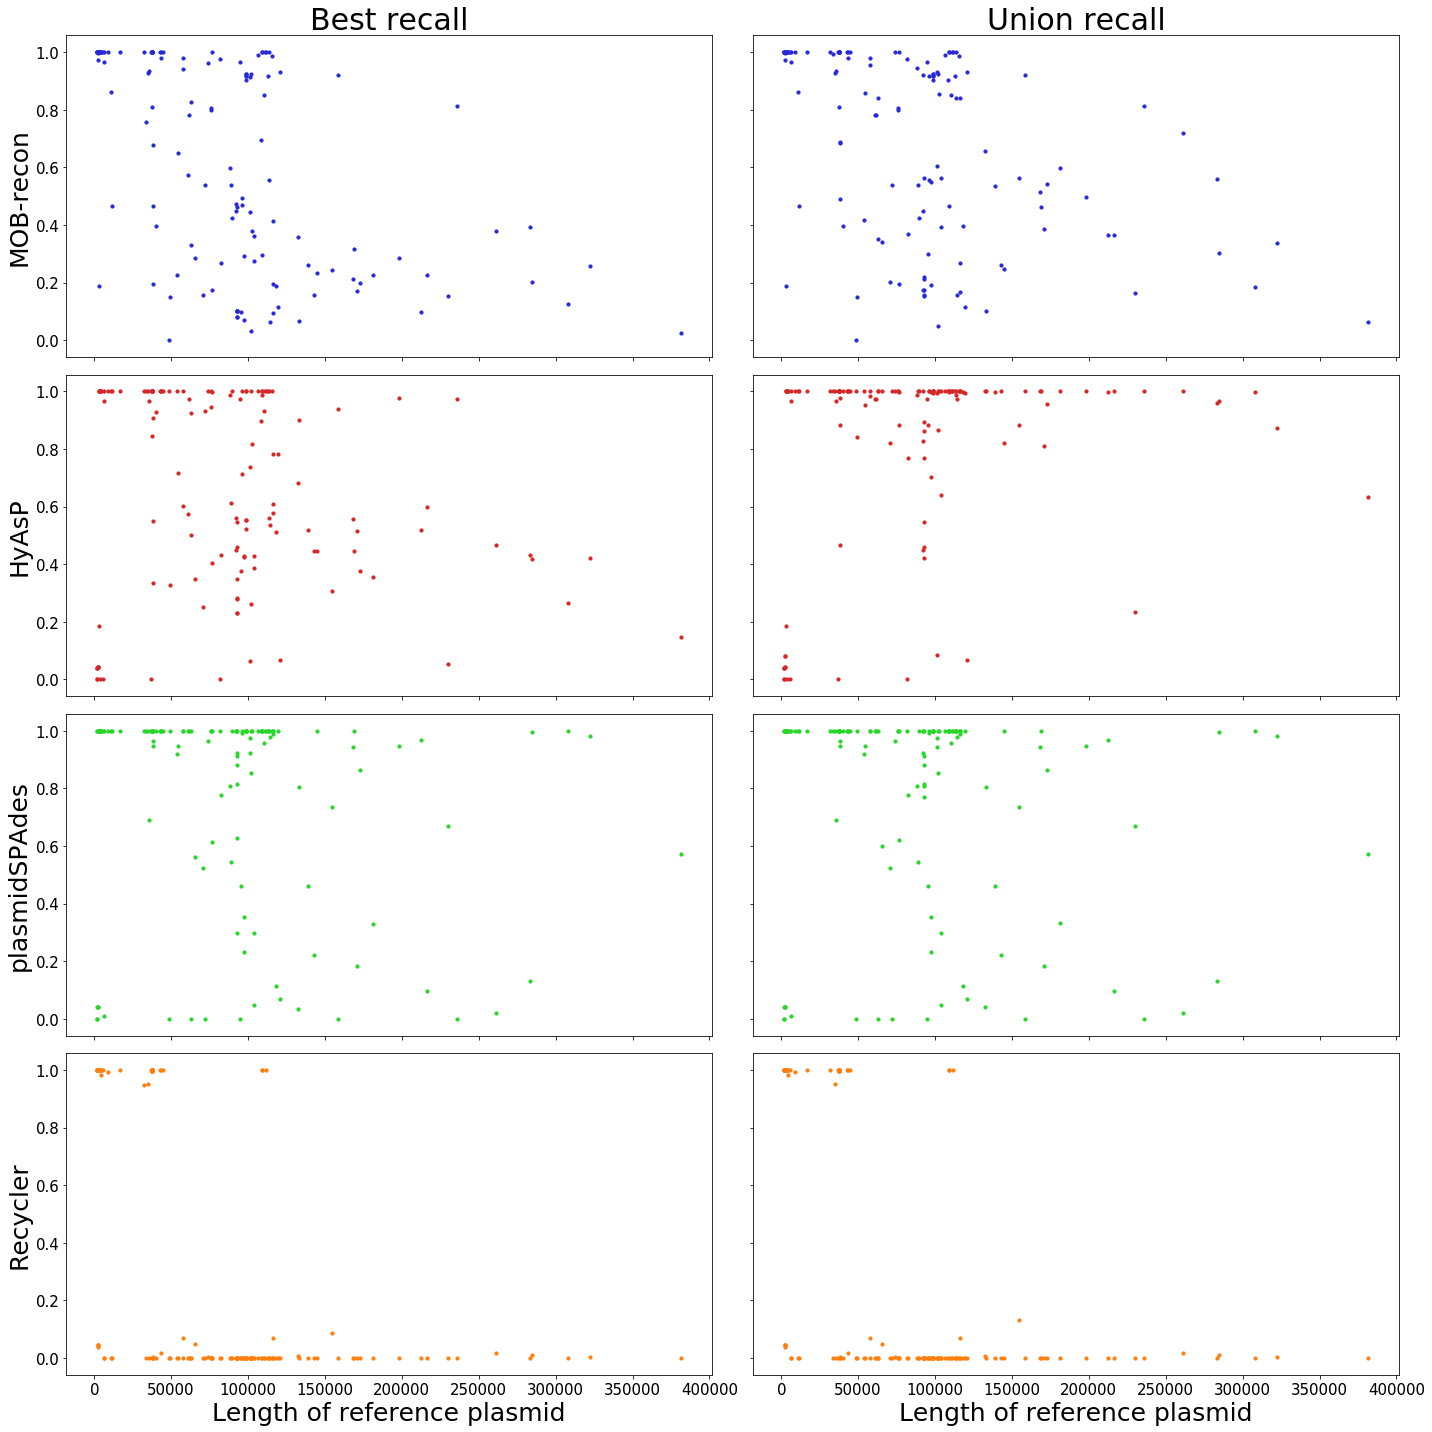

In [15]:
cols = ['max_recall', 'union_recall']
col_titles = ['Best recall', 'Union recall']
xlabel = 'Length of reference plasmid'

pretty_plots(ncbi_references, cols, col_titles, xlabel, 'length_vs_recall_ncbi')

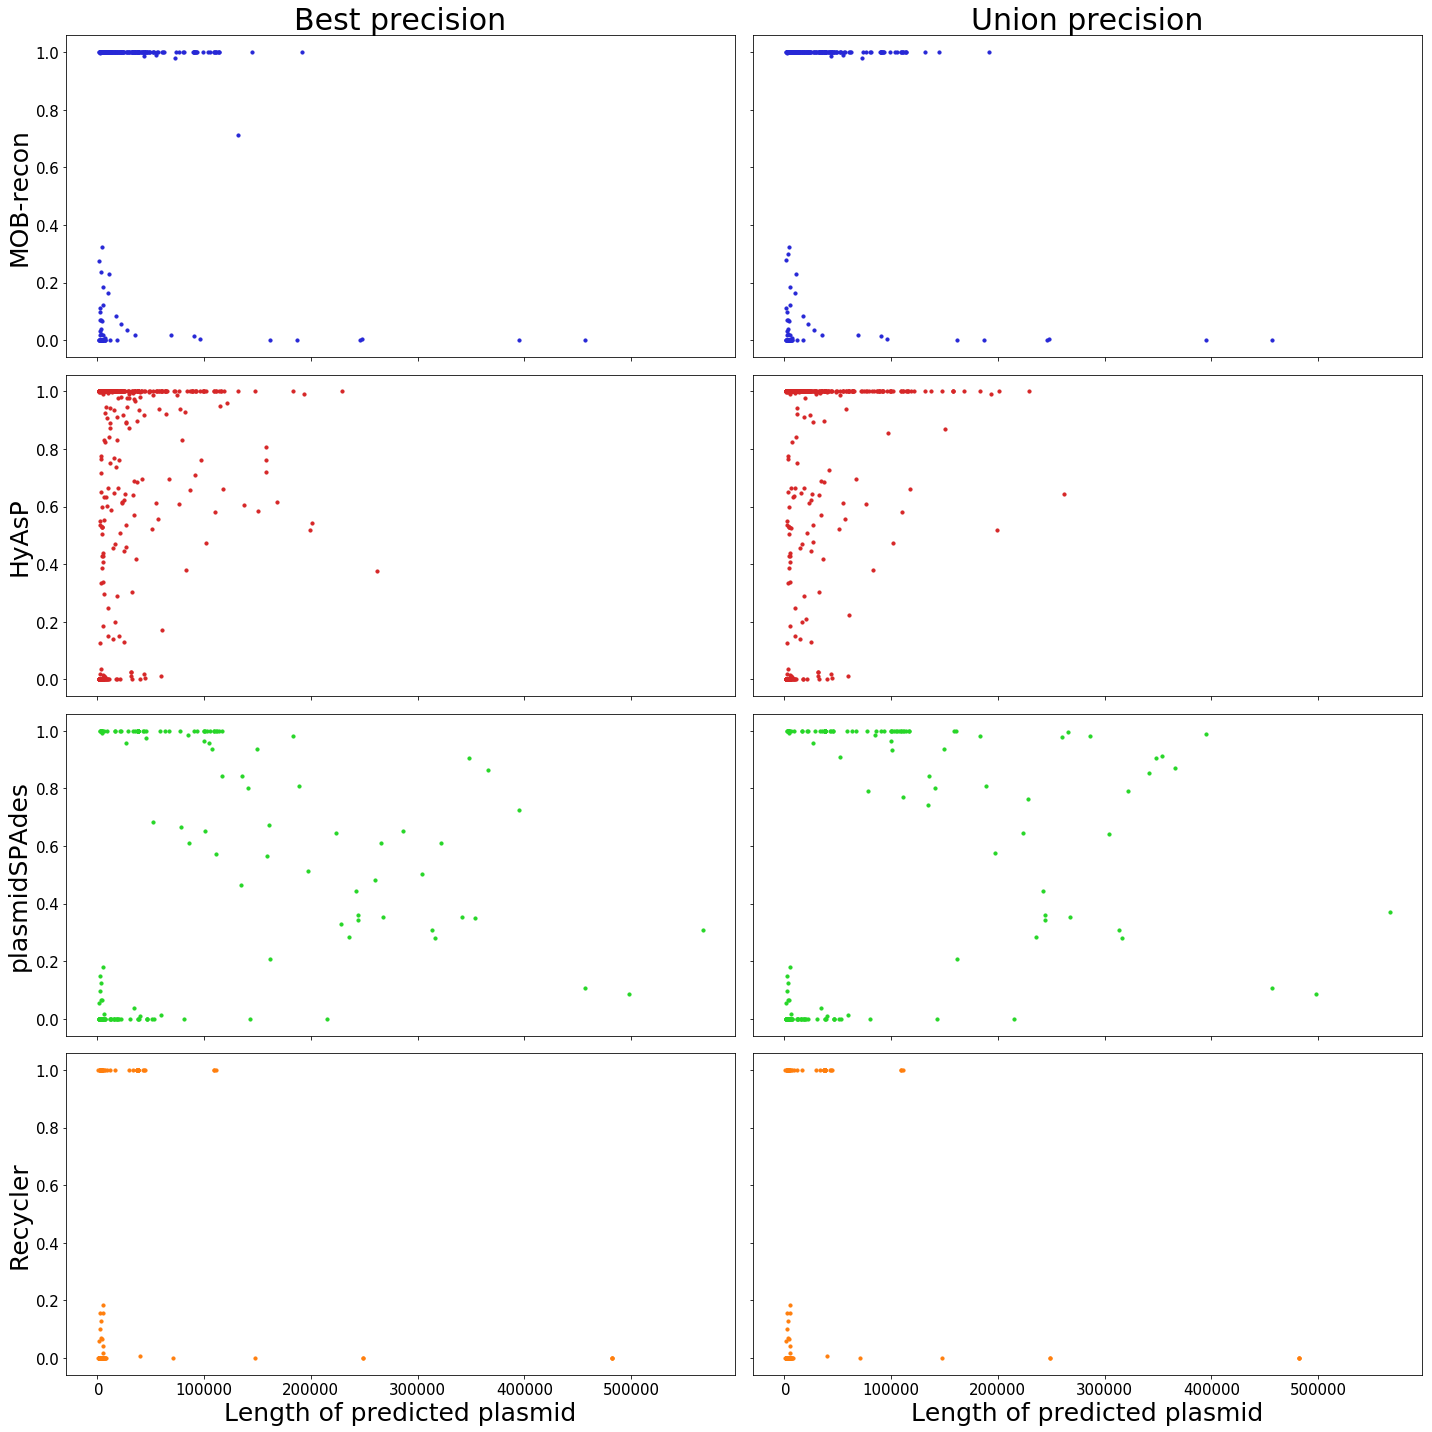

In [16]:
cols = ['max_precision', 'union_precision']
col_titles = ['Best precision', 'Union precision']
xlabel = 'Length of predicted plasmid'

pretty_plots(ncbi_predictions, cols, col_titles, xlabel, 'length_vs_precision_ncbi')

*Threshold on precision / recall for high quality*

In [17]:
threshold

0.9

**Number of high-quality pairs between references and predictions (high recall and precision)**

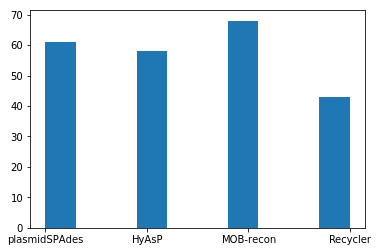

In [18]:
plt.hist(list(ncbi_pairs['tool']));

*Proportion of references (in number of references) matched with high precision and recall*

In [19]:
ncbi_pairs['tool'].value_counts() / ncbi_references['tool'].value_counts()

HyAsP            0.394558
MOB-recon        0.462585
Recycler         0.292517
plasmidSPAdes    0.414966
Name: tool, dtype: float64

*Proportion of references (in number of nucleotides) matched with high precision and recall*

In [20]:
ref_lengths = dict()
for i, row in ncbi_references.iterrows():
    ref_lengths[row['plasmid_id']] = row['length']
total_ref_len = sum([ref_lengths[i] for i in ref_lengths])
len_per_pool = [(sum([ref_lengths[i] for i in ncbi_pairs[ncbi_pairs['tool'] == t]['reference'].unique()])) / total_ref_len for t in ncbi_references['tool'].unique()]

pd.Series(data = len_per_pool, index = ncbi_references['tool'].unique())

Recycler         0.100085
plasmidSPAdes    0.291144
MOB-recon        0.263906
HyAsP            0.273021
dtype: float64

**Number of references (predictions) with high recall (precision)**

*Towards recall*: Over all samples, `num_references` plasmids were expected, of which `num_ref_hq_union` resp. `num_ref_hq_max` were sufficiently covered by the predicted plasmids, using (per sample) all predictions resp. only the most-fitting one.

*Towards precision*: Similarly, `num_predictions` plasmids were predicted, of which `num_pred_hq_union` resp. `num_pred_hq_max` were sufficiently covered by the expected reference plasmids, using (per sample) all references resp. only the most-fitting one.

In [21]:
hq_one_way(ncbi_references, ncbi_predictions, 0.9)

,tool,num_references,num_ref_hq_union,num_ref_hq_max,num_predictions,num_pred_hq_union,num_pred_hq_max
0,HyAsP,147,107,69,490,313,291
1,MOB-recon,147,74,69,286,232,231
2,plasmidSPAdes,147,103,103,166,78,67
3,Recycler,147,42,42,108,49,49
